# The Evidence Approximation

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from numpy.linalg import inv, norm, det

In [5]:
%config InlineBackend.figure_format = "retina"

### Creating the Sinusoidal Synthetic Data

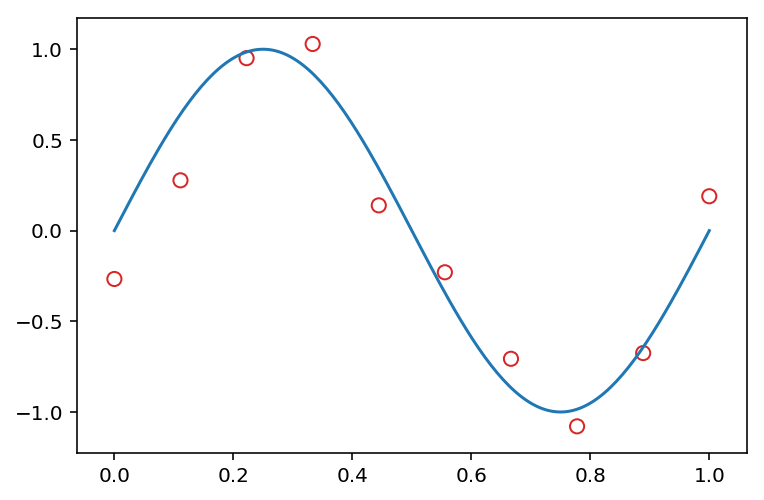

In [266]:
seed(1643)

nsteps = 200
x = np.linspace(0, 1, 200)
t_true = np.sin(2 * np.pi * x)

precision = 1 / 0.15
N = 10
x_train = np.linspace(0, 1, N)
t_train = np.sin(2 * np.pi * x_train) + randn(N) / precision

plt.plot(x, t_true)
plt.scatter(x_train, t_train, edgecolors="tab:red", c="None", s=50);

## The Setting
Under the context for a Gaussian linear regression with basis functions, given model $M_i$, seen training data $\bf t$ and a target vector $\bf x$,

$$
    p(t | {\bf t}, {\bf x}, M_i) = \int\int\int p(t, \alpha, \beta, {\bf w} | {\bf t}, {\bf x}, M_i) \ d{\bf w} \ d\alpha  \ d\beta
$$

With priors
$$
    p({\bf w} | {\bf t}, \alpha, \beta) = \mathcal{N}({\bf w} | m_N, S_N)
$$
$$
    p(t | {\bf w}, \beta) = \mathcal{N}(t | \Phi {\bf w}, \beta^{-1})
$$

For a given model $M_i$, the log-evidence function is given by
$$
    \log p(t | \alpha, \beta) = -\frac{N}{2} \log 2\pi + \frac{N}{2}\log\beta + \frac{M}{2}\log\alpha - \frac{1}{2}\log |S_N^{-1}| - E(m_N)
$$

Where
* $S_N^{-1} = \alpha {\bf I} + \beta \Phi^T\Phi$
* $m_N = \beta S_N \Phi^T {\bf t}$
* $E(m_N) = \frac{\beta}{2}{||{\bf t} - \Phi m_N||}^2 + \frac{\alpha}{2}m_N^Tm_N$

In [267]:
def gaussian_kernel(x, mu, s): return np.exp(-(x - mu)**2 / (2 * s ** 2))

In [271]:
alpha, beta = 0.1, precision
def log_evidence(M):
    mus = np.linspace(0, 1, M)
    Phi = gaussian_kernel(x_train[:, np.newaxis], mus[np.newaxis, :], 0.5)
    S_N = inv(alpha + beta * Phi.T @ Phi)
    m_N = beta * S_N @ Phi.T @ t_train[:, np.newaxis]
    
    E_mN = beta / 2 * norm(t_train[:, np.newaxis] - Phi @ m_N) ** 2 + alpha / 2 * m_N.T @ m_N
    log_ev = N / 2 * np.log(beta) + M / 2 * np.log(alpha) - \
             1 / 2 * np.log(det(S_N)) - E_mN - N / 2  * np.log(2 * np.pi)
    return log_ev.ravel()[0]

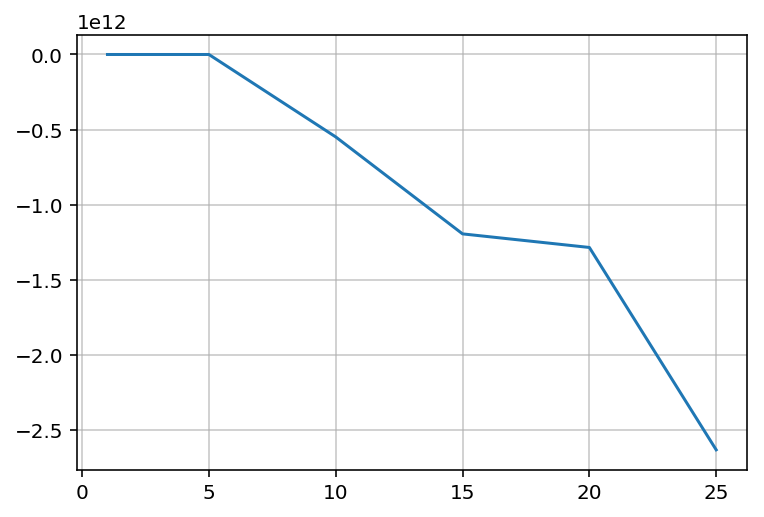

In [272]:
models = [1, 3, 5, 10, 15, 20, 25]
evidences = [log_evidence(M) for M in models]

plt.plot(models, evidences)
plt.grid(alpha=0.7)

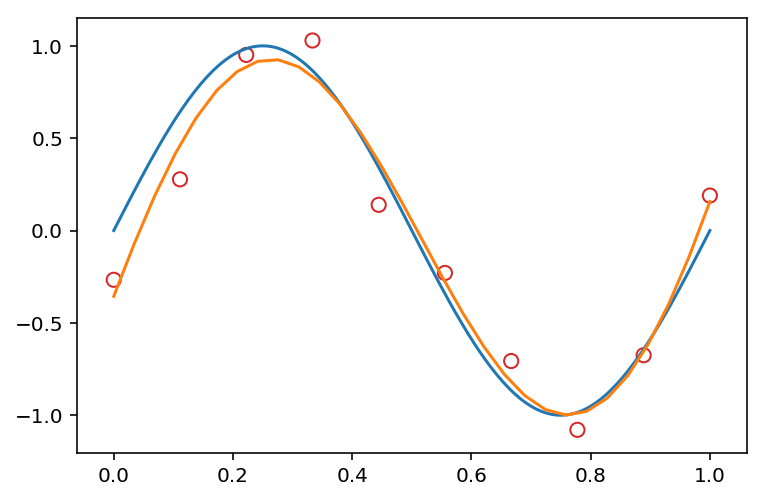

In [270]:
x_in = np.linspace(0, 1, 30)
phi_x = gaussian_kernel(x_in[:, np.newaxis], mus[np.newaxis, :], 0.5).T

plt.scatter(x_train, t_seen, edgecolors="tab:red", c="None", s=50);
plt.plot(x, t_true)
plt.plot(x_in, phi_x.T @ m_N)